In [1]:
import pandas as pd
import numpy as np



In [2]:
i=0
lis=[]
with open("ner.txt","r+") as file:
    for line in file:
        if line.startswith('\n'):
            i+=1
            continue
        line1='sent'+str(i) + ' '+line
        #print(line1) 
        lis.append(line1)
with open("out.txt", "w") as f1:
    f1.writelines(lis)



In [3]:
data = pd.read_csv("out.txt",sep=" ",encoding="latin1",names=["Sentence #","Word", "Tag"])

In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")

In [5]:
n_words = len(words); n_words

11312

In [6]:
tags = list(set(data["Tag"].values))

In [7]:
n_tags = len(tags); n_tags

3

In [55]:
tags


['O', 'T', 'D']

In [8]:
data.dtypes

Sentence #    object
Word          object
Tag           object
dtype: object

In [67]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,t) for w,t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        #print(self.sentences)
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [68]:
getter = SentenceGetter(data)

In [20]:
sentences = getter.sentences

In [69]:
#sentences

In [22]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [23]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [24]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

In [25]:
#X

In [26]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [27]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [28]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

In [29]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional


In [30]:
from keras_contrib.layers import CRF

In [31]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [32]:
model = Model(input, out)

In [33]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            226260    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 3)             168       
Total params: 259,878
Trainable params: 259,878
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=10,
                    validation_split=0.1, verbose=1)

Train on 2631 samples, validate on 293 samples
Epoch 1/10
2631/2631 [==============================] - 24s 9ms/step - loss: 9.0716 - acc: 0.8625 - val_loss: 8.0174 - val_acc: 0.8571
Epoch 2/10
2631/2631 [==============================] - 16s 6ms/step - loss: 8.9075 - acc: 0.8682 - val_loss: 7.9010 - val_acc: 0.8829
Epoch 3/10
2631/2631 [==============================] - 16s 6ms/step - loss: 8.8002 - acc: 0.9045 - val_loss: 7.8632 - val_acc: 0.8988
Epoch 4/10
2631/2631 [==============================] - 16s 6ms/step - loss: 8.7478 - acc: 0.9227 - val_loss: 7.8575 - val_acc: 0.9037
Epoch 5/10
2631/2631 [==============================] - 16s 6ms/step - loss: 8.7142 - acc: 0.9347 - val_loss: 7.8451 - val_acc: 0.9056
Epoch 6/10
2631/2631 [==============================] - 16s 6ms/step - loss: 8.6897 - acc: 0.9457 - val_loss: 7.8658 - val_acc: 0.9119
Epoch 7/10
2631/2631 [==============================] - 16s 6ms/step - loss: 8.6688 - acc: 0.9559 - val_loss: 7.8699 - val_acc: 0.8820
Epoch 8/

In [71]:
misclassification=0
total=0
actual=[]
predicted=[]

for i in range(X_te.shape[0]):
    p = model.predict(np.array([X_te[i]]))
    p = np.argmax(p, axis=-1)
    true = np.argmax(y_te[i], -1)
    print("{:15}   {:5}    {}".format("Word", "Actual", "Predicted"))
    print(30 * "=")
    for w, t, pred in zip(X_te[i], true, p[0]):
        total+=1
        if w != 0:
            print("     {:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))
            actual.append(tags[t])
            predicted.append(tags[pred])
            if tags[t]!=tags[pred]:
                misclassification+=1
    print("\n\n")

Word              Actual    Predicted
     We             : O     O
     hypothesize    : O     O
     that           : O     O
     activating     : O     O
     mutations      : O     O
     of             : O     O
     either         : O     O
     the            : O     O
     antimÃ1/4llerian: O     O
     hormone        : O     O
     gene           : O     O
     or             : O     O
     its            : O     O
     receptor       : O     O
     gene           : O     O
     may            : O     O
     cause          : O     O
     mÃ1/4llerian   : O     O
     duct           : O     O
     regression     : O     O
     in             : O     O
     a              : O     O
     genetic        : O     O
     female         : O     O
     during         : O     O
     embryogenesis  : O     O



Word              Actual    Predicted
     II             : O     O



Word              Actual    Predicted
     Emergency      : O     O
     !              : O     O
     Meni


Word              Actual    Predicted
     Human          : O     O
     cervico-facial : O     O
     morphogenesis  : O     O



Word              Actual    Predicted
     Coumadin       : O     O
     Aspirin        : O     O
     Reinfarction   : O     O
     Study          : O     O
     (              : O     O
     CARS           : O     O
     )              : O     O
     Investigators  : O     O



Word              Actual    Predicted
     Coronary       : D     T
     endothelial    : D     T
     dysfunction    : D     T
     in             : O     O
     humans         : O     O
     is             : O     O
     associated     : O     O
     with           : O     O
     myocardial     : D     O
     perfusion      : D     T
     defects        : D     T



Word              Actual    Predicted
     the            : O     O
     most           : O     O
     recent         : O     O
     study          : O     O
     ,              : O     O
     involving      : O     

Word              Actual    Predicted
     questions      : O     O
     about          : O     O
     health         : O     O
     practices      : O     O
     in             : O     O
     their          : O     O
     daily          : O     O
     lives          : O     O
     :              : O     O
     (              : O     O
     1              : O     O
     )              : O     O
     What           : O     O
     are            : O     O
     critical       : O     O
     care           : O     O
     nurses         : O     O
     doing          : O     O
     currently      : O     O
     to             : O     O
     stay           : O     O
     healthy        : O     O
     ?              : O     O
     (              : O     O
     2              : O     O
     )              : O     O
     Do             : O     O
     they           : O     O
     anticipate     : O     O
     making         : O     O
     any            : O     O
     changes        : O     O
  

Word              Actual    Predicted
     thus           : O     O
     ,              : O     O
     twice-daily    : O     O
     pci            : T     T
     should         : O     O
     be             : O     O
     considered     : O     O
     for            : O     O
     patients       : O     O
     with           : O     O
     ld             : D     D
     sclc           : D     D
     who            : O     O
     achieve        : O     O
     a              : O     O
     complete       : O     O
     response       : O     O
     to             : O     O
     chemoirradiation: O     O



Word              Actual    Predicted
     CONCLUSIONS    : O     O
     :              : O     O
     In             : O     O
     addition       : O     O
     to             : O     O
     the            : O     O
     considerable   : O     O
     body           : O     O
     of             : O     O
     clinical       : O     O
     evidence       : O     O
     supporting     

Word              Actual    Predicted
     Acquired       : O     T
     haemophilia    : D     T
     ,              : O     O
     an             : O     O
     unusual        : O     O
     cause          : O     O
     of             : O     O
     severe         : O     D
     postpartum     : D     D
     haemorrhage    : D     O



Word              Actual    Predicted
     The            : O     O
     rate           : O     O
     of             : O     O
     severe         : O     D
     preeclampsia   : D     D
     was            : O     O
     increased      : O     O
     significantly  : O     O
     in             : O     O
     the            : O     O
     triplet        : O     O
     group          : O     O
     12             : O     O
     of             : O     O
     53             : O     O
     (              : O     O
     22.6           : O     O
     %              : O     O
     )              : O     O
     as             : O     O
     compared       :

Word              Actual    Predicted
     In             : O     O
     patients       : O     O
     with           : O     O
     chronic        : D     D
     myeloid        : D     D
     leukemia       : D     D
     (              : D     D
     CML            : D     D
     )              : D     O
     ,              : O     O
     the            : O     O
     neoplastic     : O     O
     (              : O     O
     BCR-ABL+       : O     O
     )              : O     O
     progenitor     : O     O
     cells          : O     O
     are            : O     O
     characterized  : O     O
     by             : O     O
     an             : O     O
     increased      : O     O
     proliferative  : O     O
     activity       : O     O



Word              Actual    Predicted
     Clinical       : O     O
     familial       : O     O
     case           : O     O
     study          : O     O



Word              Actual    Predicted
     She            : O     O
     was  

Word              Actual    Predicted
     A              : O     O
     preterm        : O     O
     newborn        : O     O
     female         : O     O
     triplet        : O     O
     with           : O     O
     diffuse        : O     O
     cystic         : O     O
     changes        : O     O
     in             : O     O
     the            : O     O
     left           : O     O
     lung           : O     O



Word              Actual    Predicted
     After          : O     O
     six            : O     O
     baiting        : O     O
     campaigns      : O     O
     (              : O     O
     15-20          : O     O
     baits/km2      : O     O
     )              : O     O
     over           : O     O
     a              : O     O
     period         : O     O
     of             : O     O
     14             : O     O
     months         : O     O
     ,              : O     O
     the            : O     O
     prevalence     : O     O
     of             :

Word              Actual    Predicted
     Medical        : T     O
     treatment      : T     O
     of             : O     O
     stone          : D     D
     disease        : D     D



Word              Actual    Predicted
     Fifty-one      : O     O
     per            : O     O
     cent           : O     O
     of             : O     O
     stroke         : D     D
     victims        : O     O
     were           : O     O
     below          : O     O
     the            : O     O
     age            : O     O
     of             : O     O
     54             : O     O
     years          : O     O



Word              Actual    Predicted
     Paris          : O     O
     ,              : O     O
     France         : O     O
     ,              : O     O
     March          : O     O
     6-7            : O     O
     ,              : O     O
     1997           : O     O



Word              Actual    Predicted
     Trauma         : O     O
     and            : O     O

Word              Actual    Predicted
     Urine          : O     O
     was            : O     O
     also           : O     O
     obtained       : O     O
     from           : O     O
     subjects       : O     O
     who            : O     O
     had            : O     O
     received       : O     O
     the            : O     O
     maximum        : O     O
     dosage         : O     O
     of             : O     O
     inhaled        : O     O
     salbutamol     : T     O
     advisable      : O     O
     for            : O     O
     competing      : O     O
     athletes       : O     O
     to             : O     O
     provide        : O     O
     protection     : O     O
     from           : O     O
     exercise-induced: O     D
     asthma         : O     D
     and            : O     O
     treatment      : O     O
     of             : O     O
     asthma         : D     D
     (              : O     O
     1600           : O     O
     microg         : O     O
 

Word              Actual    Predicted
     only           : O     O
     the            : O     O
     combination    : T     O
     of             : T     O
     a              : T     O
     cell           : T     T
     wall-active    : T     T
     antibiotic     : T     T
     to             : T     O
     which          : T     O
     the            : T     O
     enterococcus   : T     O
     is             : T     O
     susceptible    : T     O
     (              : T     O
     ie             : T     O
     ,              : T     O
     certain        : T     O
     beta-lactams   : T     O
     or             : T     O
     vancomycin     : T     T
     )              : T     T
     plus           : T     T
     an             : T     O
     aminoglycoside : T     O
     (              : T     O
     ie             : T     O
     ,              : T     O
     gentamicin     : T     O
     or             : T     O
     streptomycin   : T     O
     )              : T     O
  

Word              Actual    Predicted
     Isotopic       : O     O
     evidence       : O     O
     for            : O     O
     extraterrestrial: O     O
     non-racemic    : O     O
     amino          : O     O
     acids          : O     O
     in             : O     O
     the            : O     O
     Murchison      : O     O
     meteorite      : O     O



Word              Actual    Predicted
     Treatment      : O     O
     of             : O     O
     spontaneous    : D     D
     carotid-cavernous: D     D
     fistula        : D     D
     in             : D     O
     Ehlers-Danlos  : D     D
     syndrome       : D     D
     by             : O     O
     transvenous    : T     D
     occlusion      : T     D
     with           : T     O
     Guglielmi      : T     T
     detachable     : T     T
     coils          : T     T



Word              Actual    Predicted
     It             : O     O
     is             : O     O
     possible       : O     O
     th

Word              Actual    Predicted
     Mitomycin      : T     T
     ,              : T     O
     ifosfamide     : T     T
     ,              : T     T
     and            : T     T
     cisplatin      : T     T
     in             : O     O
     unresectable   : D     D
     non-small-cell : D     D
     lung           : D     D
     cancer         : D     D
     :              : O     O
     effects        : O     O
     on             : O     O
     survival       : O     O
     and            : O     O
     quality        : O     O
     of             : O     O
     life           : O     O
     .              : O     O



Word              Actual    Predicted
     Because        : O     O
     the            : O     O
     ability        : O     O
     to             : O     O
     detect         : O     O
     UTI            : D     D
     (              : O     O
     sensitivity    : O     O
     )              : O     O
     is             : O     O
     maintained     :

     Lymphatics     : O     O
     of             : O     O
     the            : O     O
     mouth          : O     D
     and            : O     O
     neck           : O     O



Word              Actual    Predicted
     Diagnosis      : O     O
     and            : O     O
     therapy        : O     O
     of             : O     O
     primary        : O     D
     stomach        : D     D
     lymphoma       : D     D



Word              Actual    Predicted
     Rapid          : O     O
     and            : O     O
     ultrarapid     : O     O
     opioid         : T     T
     detoxification : T     T
     techniques     : O     T



Word              Actual    Predicted
     Endoscopic     : T     O
     excision       : T     O
     of             : O     O
     a              : D     O
     forehead       : D     O
     mass           : D     O



Word              Actual    Predicted
     To             : O     O
     identify       : O     O
     novel          : O   

Word              Actual    Predicted
     BACKGROUND     : O     O
     :              : O     O
     An             : O     O
     increasing     : O     O
     number         : O     O
     of             : O     O
     reports        : O     O
     indicate       : O     O
     symptomatic    : O     O
     relief         : O     O
     of             : O     O
     biliary        : O     D
     colic          : O     D
     symptoms       : O     D
     after          : O     O
     cholecystectomy: T     T
     for            : O     O
     biliary        : D     D
     dyskinesia     : D     D



Word              Actual    Predicted
     We             : O     O
     conducted      : O     O
     a              : O     O
     long-term      : O     O
     trial          : O     O
     of             : O     O
     docosahexanoic : T     O
     acid           : T     O
     (              : T     O
     DHA            : T     T
     )              : T     T
     -concentrated  :

Word              Actual    Predicted
     Neostigmine    : T     O
     for            : O     O
     acute          : D     D
     colonic        : D     D
     pseudo-obstruction: D     D



Word              Actual    Predicted
     this           : O     O
     conjugated     : T     O
     vaccine        : T     O
     against        : O     O
     pneumococcus   : D     O
     uses           : O     O
     the            : O     O
     same           : O     O
     technology     : O     O
     as             : O     O
     the            : O     O
     successful     : O     O
     vaccine        : T     O
     against        : O     O
     haemophilus    : D     O
     influenzae     : D     D
     type           : D     D
     b              : D     D



Word              Actual    Predicted
     Linkage        : O     O
     analysis       : O     O
     assigned       : O     O
     six            : O     O
     of             : O     O
     them           : O     O
     to

Word              Actual    Predicted
     Glucose        : O     T
     can            : O     O
     be             : O     O
     measured       : O     O
     in             : O     O
     the            : O     O
     range          : O     O
     0.6-20.0       : O     O
     mM             : O     O
     in             : O     O
     the            : O     O
     O2             : O     O
     range          : O     O
     20-100         : O     O
     %              : O     O



Word              Actual    Predicted
     Occupational   : T     O
     therapy        : T     O
     and            : O     O
     outcomes       : O     O
     for            : O     O
     older          : O     O
     adults         : O     O



Word              Actual    Predicted
     Survanta       : O     O
     in             : O     O
     Term           : O     O
     Infants        : O     O
     Study          : O     O
     Group          : O     O



Word              Actual    Predicted

Word              Actual    Predicted
     In             : O     O
     case           : O     O
     3              : O     O
     ,              : O     O
     intravenous    : T     O
     cidofovir      : T     T
     therapy        : T     T
     was            : O     O
     started        : O     O
     both           : O     O
     for            : O     O
     CMV            : D     T
     retinitis      : D     T
     and            : O     O
     in             : O     O
     an             : O     O
     attempt        : O     O
     to             : O     O
     clear          : O     O
     90             : O     O
     %              : O     O
     facial         : O     O
     MCV            : D     D
     involvement    : O     O
     ;              : O     O
     after          : O     O
     1              : O     O
     month          : O     O
     of             : O     O
     treatment      : O     O
     ,              : O     O
     all            : O     O
  

Word              Actual    Predicted
     Research       : O     O
     into           : O     O
     sexual         : O     O
     orientation-simplistically: O     O
     referred       : O     O
     to             : O     O
     as             : O     O
     ``             : O     O
     gay            : O     O
     gene           : O     O
     ''             : O     O
     research-is    : O     O
     an             : O     O
     example        : O     O
     of             : O     O
     research       : O     O
     that           : O     O
     provokes       : O     O
     intense        : O     O
     controversy    : O     O



Word              Actual    Predicted
     High           : O     O
     energy         : O     O
     roentgen       : O     O
     ray            : O     O
     contamination  : O     O
     of             : O     O
     the            : O     O
     electron       : O     O
     beam           : O     O
     from           : O     O
     a    

Word              Actual    Predicted
     Municipal      : O     O
     animal         : O     O
     control        : O     O
     ordinances     : O     O
     --             : O     O
     some           : O     O
     legal          : O     O
     issues         : O     O



Word              Actual    Predicted
     Sequential     : O     O
     MR             : O     O
     studies        : O     O
     were           : O     O
     obtained       : O     O
     within         : O     O
     1              : O     O
     to             : O     O
     3              : O     O
     days           : O     O
     postoperatively: O     O
     and            : O     O
     at             : O     O
     6-month        : O     O
     follow-up      : O     O
     examination    : O     O



Word              Actual    Predicted
     Patients       : O     O
     with           : O     O
     classical      : O     T
     symptoms       : O     T
     such           : O     O
     as   

Word              Actual    Predicted
     Human          : D     O
     papillomavirus : D     O
     types          : O     O
     52             : O     O
     and            : O     O
     58             : O     O
     are            : O     O
     prevalent      : O     O
     in             : O     O
     cervical       : D     O
     cancer         : D     O
     from           : O     O
     Chinese        : O     O
     women          : O     O



Word              Actual    Predicted
     The            : O     O
     role           : O     O
     of             : O     O
     the            : O     O
     liver          : O     O
     in             : O     O
     serum-induced  : O     O
     hypercoagulability: D     O



Word              Actual    Predicted
     The            : O     O
     total          : O     O
     cesarean       : O     O
     rate           : O     O
     was            : O     O
     14.4           : O     O
     %              : O     O
     ( 

Word              Actual    Predicted
     Supramaximal   : T     D
     horizontal     : T     D
     rectus         : T     D
     surgery        : T     D
     in             : O     O
     the            : O     O
     management     : O     O
     of             : O     O
     third          : D     D
     and            : D     D
     sixth          : D     D
     nerve          : D     D
     palsy          : D     D



Word              Actual    Predicted
     covered        : O     O
     or             : O     O
     noncovered     : O     T
     metallic       : T     T
     stents         : T     T
     were           : O     O
     used           : O     O
     for            : O     O
     the            : O     O
     esophageal     : D     D
     stenoses       : D     D
     ,              : O     O
     except         : O     O
     in             : O     O
     1              : O     O
     patient        : O     O
     treated        : O     O
     with           :

Word              Actual    Predicted
     No             : O     O
     major          : O     O
     drug-related   : O     O
     adverse        : O     O
     effects        : O     O
     were           : O     O
     observed       : O     O



Word              Actual    Predicted
     )              : O     O



Word              Actual    Predicted
     It             : O     O
     is             : O     O
     still          : O     O
     unclear        : O     O
     ,              : O     O
     however        : O     O
     ,              : O     O
     how            : O     O
     the            : O     O
     use            : O     O
     of             : O     O
     these          : O     O
     substrates     : O     O
     is             : O     O
     regulated      : O     O
     during         : O     O
     exercise       : O     O



Word              Actual    Predicted
     STUDY          : O     O
     DESIGN         : O     O
     :              : O     O

Word              Actual    Predicted
     A              : O     O
     retrospective  : O     O
     sequential     : O     O
     review         : O     O
     was            : O     O
     made           : O     O
     of             : O     O
     the            : O     O
     last           : O     O
     100            : O     O
     physical       : O     O
     medicine       : O     O
     and            : O     O
     rehabilitation : O     O
     consultations  : O     O
     with           : O     O
     student        : O     O
     attendance     : O     O



Word              Actual    Predicted
     d-penicillamine: T     O
     (              : T     O
     2-amino-3-mercapto-3-methylbutanoic: T     O
     acid           : T     O
     )              : T     O
     ,              : T     O
     a              : T     O
     well-known     : T     O
     heavy          : T     O
     metal          : T     T
     chelator       : T     T
     ,              : O     O
 

Word              Actual    Predicted
     Prior          : O     D
     attendance     : O     D
     with           : O     O
     upper          : D     D
     respiratory    : D     D
     conditions     : D     O
     was            : O     O
     also           : O     O
     associated     : O     O
     with           : O     O
     increased      : O     O
     reattendance   : O     O



Word              Actual    Predicted
     Comparison     : O     O
     of             : O     O
     neutral        : O     O
     fat            : O     O
     and            : O     O
     free           : O     O
     fatty          : O     O
     acids          : O     O
     in             : O     O
     high           : O     O
     lipid-low      : O     O
     carbohydrate   : O     O
     diets          : O     O
     for            : O     O
     the            : O     O
     growing        : O     O
     chicken        : O     O



Word              Actual    Predicted
     concl

Word              Actual    Predicted
     The            : O     O
     purpose        : O     O
     of             : O     O
     this           : O     O
     study          : O     O
     was            : O     O
     to             : O     O
     determine      : O     O
     if             : O     O
     topical        : T     O
     DL-alpha-tocopherol: T     O
     (              : T     O
     vitamin        : T     O
     E              : T     O
     )              : T     O
     could          : O     O
     reduce         : O     O
     ultraviolet-induced: D     O
     damage         : D     O
     to             : D     O
     the            : D     O
     epidermis      : D     O



Word              Actual    Predicted
     A              : O     O
     substantial    : O     O
     fraction       : O     O
     of             : O     O
     the            : O     O
     organic        : O     O
     compounds      : O     O
     on             : O     O
     the     

     an             : O     O
     asymmetric     : O     O
     centre         : O     O
     ,              : O     O
     occurring      : O     O
     as             : O     O
     laevorotatory  : O     O
     ,              : O     O
     L              : O     O
     ,              : O     O
     or             : O     O
     dextrorotatory : O     O
     ,              : O     O
     D              : O     O
     ,              : O     O
     compounds      : O     O



Word              Actual    Predicted
     The            : O     O
     activity       : O     O
     of             : O     O
     hepatic        : O     O
     glutamine      : O     O
     synthetase     : O     O
     was            : O     O
     markedly       : O     O
     reduced        : O     O
     (              : O     O
     in             : O     O
     patient        : O     O
     1              : O     O
     ,              : O     O
     12             : O     O
     %              : O     O

Word              Actual    Predicted
     Hazards        : O     O
     of             : O     O
     running        : O     O
     a              : O     O
     marathon       : O     O



Word              Actual    Predicted
     The            : O     O
     role           : O     O
     of             : O     O
     the            : O     O
     extracellular  : O     O
     signal-related : O     O
     kinase         : O     O
     (              : O     O
     ERK            : O     O
     )              : O     O
     signaling      : O     O
     pathway        : O     O
     in             : O     O
     the            : O     O
     HMGI-C         : O     O
     induction      : O     O
     was            : O     O
     highlighted    : O     O
     by             : O     O
     the            : O     O
     result         : O     O
     that           : O     O
     the            : O     O
     MAP            : O     O
     kinase         : O     O
     kinase         :

Word              Actual    Predicted
     Comparison     : O     O
     of             : O     O
     AF-4           : O     O
     protein        : O     O
     coding         : O     O
     sequences      : O     O
     with           : O     O
     the            : O     O
     LAF-4          : O     O
     and            : O     O
     FMR-2          : O     O
     sequences      : O     O
     revealed       : O     O
     five           : O     O
     highly         : O     O
     conserved      : O     O
     domains        : O     O
     of             : O     O
     potential      : O     O
     functional     : O     O
     relevance      : O     O



Word              Actual    Predicted
     The            : O     O
     effectiveness  : O     O
     of             : O     O
     glucocorticoids: T     O
     in             : O     O
     treating       : O     O
     croup          : D     D
     :              : O     O
     meta-analysis  : O     O
     (              :

Word              Actual    Predicted
     Humoral        : O     T
     immune         : O     T
     response       : O     O
     after          : O     O
     vaccination    : T     T
     against        : O     O
     influenza      : D     D
     in             : O     O
     patients       : O     O
     with           : O     O
     breast         : O     D
     cancer         : O     D



Word              Actual    Predicted
     Should         : O     O
     we             : O     O
     accept         : O     O
     mediocrity     : O     O
     ?              : O     O



Word              Actual    Predicted
     Consumption    : O     O
     of             : O     O
     alcohol        : O     O
     and            : O     O
     mortality      : O     O
     in             : O     O
     Russia         : O     O



Word              Actual    Predicted
     Effects        : O     O
     of             : O     O
     tryptophan     : O     O
     mustard        : O     O

     antibiotic     : O     O
     susceptibility : O     O
     or             : O     O
     increase       : O     O
     in             : O     O
     resistance     : O     O
     ?              : O     O



Word              Actual    Predicted
     121            : O     O



Word              Actual    Predicted
     New            : O     O
     Zealand        : O     O
     Cot            : O     O
     Death          : O     O
     Study          : O     O
     Group          : O     O



Word              Actual    Predicted
     A              : O     O
     preliminary    : O     O
     report         : O     O



Word              Actual    Predicted
     Family         : O     O
     history        : O     O
     and            : O     O
     genetic        : O     O
     risk           : O     O
     factors        : O     O
     :              : O     O
     forward        : O     O
     to             : O     O
     the            : O     O
     future         : O   

Word              Actual    Predicted
     Diabetic       : O     O
     retinopathy    : O     D
     ,              : O     O
     promoter       : O     O
     (              : O     O
     4G/5G          : O     O
     )              : O     O
     polymorphism   : O     O
     of             : O     O
     PAI-1          : O     O
     gene           : O     O
     ,              : O     O
     and            : O     O
     PAI-1          : O     O
     activity       : O     O
     in             : O     O
     Pima           : O     O
     Indians        : O     O
     with           : O     O
     type           : O     O
     2              : O     O
     diabetes       : D     D



Word              Actual    Predicted
     Psychosexual   : D     O
     problems       : D     O



Word              Actual    Predicted
     Evaluation     : O     O
     of             : O     O
     the            : O     O
     microparticle  : O     O
     enzyme         : O     O
     immun

Word              Actual    Predicted
     120            : O     O



Word              Actual    Predicted
     Presentations  : O     O
     from           : O     O
     the            : O     O
     2nd            : O     O
     NIH            : O     O
     Symposium      : O     O
     on             : O     O
     Therapeutic    : O     O
     Oligonucleotides: O     O
     :              : O     O
     Targeting      : O     O
     Transcription  : O     O
     Factors        : O     O
     and            : O     O
     Signaling      : O     O
     Pathways       : O     O



Word              Actual    Predicted
     Neutrophils    : O     O
     from           : O     O
     the            : O     O
     peripheral     : O     O
     blood          : O     O
     of             : O     O
     these          : O     O
     participants   : O     O
     and            : O     O
     from           : O     O
     healthy        : O     O
     controls       : O     O
     were

Word              Actual    Predicted
     Tubularized    : T     D
     incised        : T     D
     plate          : T     D
     hypospadias    : T     D
     repair         : T     O
     for            : O     O
     proximal       : D     D
     hypospadias    : D     D



Word              Actual    Predicted
     After          : O     O
     a              : O     O
     median         : O     O
     follow-up      : O     O
     of             : O     O
     87             : O     O
     (              : O     O
     range          : O     O
     57-120         : O     O
     )              : O     O
     months         : O     O
     ,              : O     O
     5-year         : O     O
     overall        : O     O
     and            : O     O
     disease-free   : O     O
     survival       : O     O
     were           : O     O
     identical      : O     O
     in             : O     O
     the            : O     O
     surgery        : O     O
     and            :

Word              Actual    Predicted
     Familial       : D     O
     vitamin        : D     O
     D              : D     O
     resistant      : D     O
     rickets        : D     O
     in             : O     O
     untreated      : O     O
     adult          : O     O



Word              Actual    Predicted
     Screening      : O     O
     all            : O     O
     women          : O     O
     aged           : O     O
     &              : O     O
     #              : O     O
     60             : O     O
     ;              : O     O
     or             : O     O
     =              : O     O
     25             : O     O
     and            : O     O
     all            : O     O
     women          : O     O
     who            : O     O
     had            : O     O
     had            : O     O
     two            : O     O
     or             : O     O
     more           : O     O
     partners       : O     O
     in             : O     O
     the            :

     asthma         : D     D
     are            : O     O
     accompanied    : O     O
     by             : O     O
     clinically     : O     O
     significant    : O     O
     improvements   : O     O
     in             : O     O
     quality        : O     O
     of             : O     O
     life           : O     O



Word              Actual    Predicted
     Case           : O     O
     30-1997        : O     O



Word              Actual    Predicted
     The            : O     O
     gene           : O     O
     contains       : O     O
     two            : O     O
     alternative    : O     O
     first          : O     O
     exons          : O     O
     ,              : O     O
     1a             : O     O
     and            : O     O
     1b             : O     O
     ,              : O     O
     both           : O     O
     including      : O     O
     a              : O     O
     translation    : O     O
     initiation     : O     O
     codon        

Word              Actual    Predicted
     carboplatin    : T     T
     and            : T     T
     ifosfamide     : T     T
     performed      : O     O
     well           : O     O
     and            : O     O
     safe           : O     O
     ,              : O     O
     in             : O     O
     the            : O     O
     treatment      : O     O
     of             : O     O
     non-bulky      : D     D
     metastatic     : D     D
     seminoma       : D     D



Word              Actual    Predicted
     Another        : O     O
     potential      : O     O
     use            : O     O
     of             : O     O
     troglitazone   : T     T
     in             : O     O
     noninsulin-dependent: D     D
     diabetes       : D     D
     mellitus       : D     D



Word              Actual    Predicted
     All            : O     O
     patients       : O     O
     with           : O     O
     MS             : O     O
     were           : O     O
     

Word              Actual    Predicted
     Epitome        : O     O
     of             : O     O
     myocarditis    : D     D



Word              Actual    Predicted
     An             : O     O
     amperometric   : O     O
     lactate        : O     O
     oxidase        : O     O
     catheter       : O     O
     has            : O     O
     been           : O     O
     developed      : O     O
     for            : O     O
     in             : O     O
     vivo           : O     O
     application    : O     O
     to             : O     O
     real-time      : O     O
     lactate        : O     O
     monitoring     : O     O



Word              Actual    Predicted
     Marseille      : O     O
     ,              : O     O
     France         : O     O
     ,              : O     O
     28-30          : O     O
     April          : O     O
     1998           : O     O



Word              Actual    Predicted
     <              : O     O
     TO_SEE         : O     O

Word              Actual    Predicted
     It             : O     O
     has            : O     O
     been           : O     O
     reported       : O     O
     previously     : O     O
     that           : O     O
     amino          : O     O
     acids          : O     O
     in             : O     O
     the            : O     O
     Murchison      : O     O
     meteorite      : O     O
     exhibit        : O     O
     an             : O     O
     excess         : O     O
     of             : O     O
     L-enantiomers  : O     O
     ,              : O     O
     raising        : O     O
     the            : O     O
     possibility    : O     O
     that           : O     O
     a              : O     O
     similar        : O     O
     excess         : O     O
     was            : O     O
     present        : O     O
     in             : O     O
     the            : O     O
     initial        : O     O
     inventory      : O     O
     of             : O     O
  

     to             : O     O
     these          : O     O
     adverse        : O     O
     events         : O     O
     were           : O     O
     also           : O     O
     significantly  : O     O
     reduced        : O     O
     in             : O     O
     patients       : O     O
     receiving      : O     O
     amifostine     : O     O
     versus         : O     O
     patients       : O     O
     receiving      : O     O
     chemotherapy   : O     O
     alone          : O     O



Word              Actual    Predicted
     Automation     : O     O
     in             : O     O
     cervical       : O     O
     cytology       : O     O
     :              : O     O
     whose          : O     O
     cost           : O     O
     and            : O     O
     whose          : O     O
     benefit        : O     O
     ?              : O     O



Word              Actual    Predicted
     This           : O     O
     study          : O     O
     indicates    

Word              Actual    Predicted
     Ellipsometry   : O     O
     measurements   : O     O
     of             : O     O
     oxygen         : O     O
     plasma         : O     O
     exposed        : O     O
     antibody       : O     O
     layers         : O     O
     indicated      : O     O
     complete       : O     O
     removal        : O     O
     of             : O     O
     immobilized    : O     O
     antibodies     : O     O



Word              Actual    Predicted
     An             : O     O
     economic       : O     O
     analysis       : O     O
     of             : O     O
     different      : O     O
     strategies     : O     O
     of             : O     O
     immunization   : T     O
     against        : O     O
     hepatitis      : D     D
     A              : D     O
     virus          : D     O
     in             : O     O
     developed      : O     O
     countries      : O     O



Word              Actual    Predicted
     137  

Word              Actual    Predicted
     Pure           : D     T
     alexia         : D     T
     could          : O     O
     not            : O     O
     be             : O     O
     a              : O     O
     disconnection  : O     O
     syndrome       : O     O



Word              Actual    Predicted
     At             : O     O
     293            : O     O
     sites          : O     O
     ,              : O     O
     we             : O     O
     randomly       : O     O
     assigned       : O     O
     8803           : O     O
     patients       : O     O
     who            : O     O
     had            : O     O
     had            : O     O
     myocardial     : D     T
     infarction     : D     T
     ,              : O     O
     treatment      : O     O
     with           : O     O
     160            : T     O
     mg             : T     O
     aspirin        : T     O
     ,              : O     O
     3              : T     O
     mg             :

Word              Actual    Predicted
     METHODS        : O     O
     :              : O     O
     The            : O     O
     effect         : O     O
     of             : O     O
     roxithromycin  : T     O
     was            : O     O
     assessed       : O     O
     in             : O     O
     a              : O     O
     double-blind   : O     O
     ,              : O     O
     randomised     : O     O
     ,              : O     O
     prospective    : O     O
     ,              : O     O
     multicentre    : O     O
     ,              : O     O
     parallel-group : O     O
     ,              : O     O
     placebo-controlled: O     O
     pilot          : O     O
     study          : O     O
     of             : O     O
     202            : O     O
     patients       : O     O
     with           : O     O
     unstable       : D     D
     angina         : D     D
     or             : O     D
     non-Q-wave     : D     D
     myocardial     : D     D

Word              Actual    Predicted
     The            : O     O
     odds           : O     O
     ratios         : O     O
     for            : O     O
     retinopathy    : D     D
     in             : O     O
     subjects       : O     O
     with           : O     O
     4G/4G          : O     O
     and            : O     O
     4G/5G          : O     O
     ,              : O     O
     compared       : O     O
     with           : O     O
     the            : O     O
     5G/5G          : O     O
     genotype       : O     O
     ,              : O     O
     were           : O     O
     2.0            : O     O
     and            : O     O
     3.1            : O     O
     ,              : O     O
     respectively   : O     O



Word              Actual    Predicted
     Early          : O     O
     introduction   : O     O
     of             : O     O
     enteral        : O     O
     feeds          : O     O
     and            : O     O
     the            :

In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(actual, predicted)

0.91470811220621684

In [45]:
total

54825

In [42]:
misclassification

1125

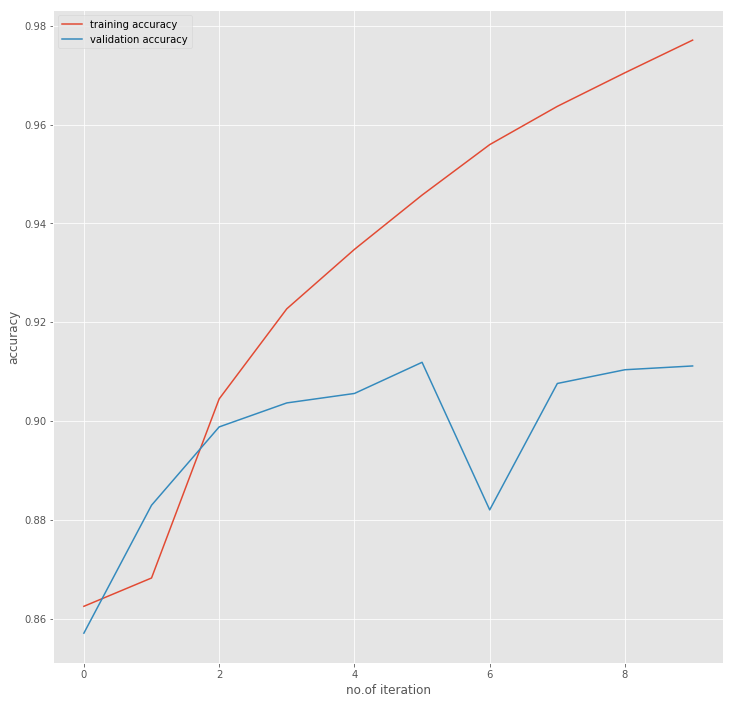

In [46]:
hist = pd.DataFrame(history.history)
import matplotlib.pyplot as plt
import pylab 
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
pylab.plot(hist["acc"],label='training accuracy')
pylab.xlabel("no.of iteration")
pylab.ylabel("accuracy")
pylab.plot(hist["val_acc"],label='validation accuracy')
pylab.legend(loc='upper left')
plt.show()


In [48]:

from sklearn.metrics import confusion_matrix
p=confusion_matrix(actual, predicted)

In [49]:
print(p)

[[  623   281    83]
 [  164 11107   229]
 [   34   334   335]]


Normalized confusion matrix
[[ 0.63120567  0.28470111  0.08409321]
 [ 0.01426087  0.96582609  0.01991304]
 [ 0.04836415  0.47510669  0.47652916]]


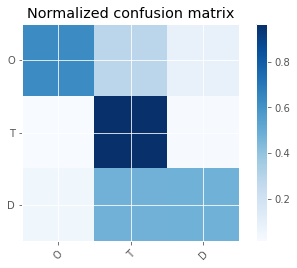

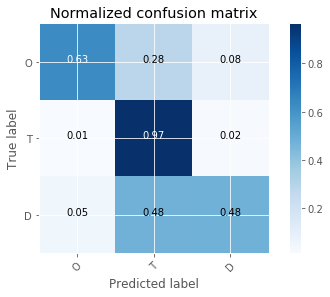

In [57]:
import itertools
import matplotlib.pyplot as plt
plt.figure()
plot_confusion_matrix(p, classes=tags, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[  623   281    83]
 [  164 11107   229]
 [   34   334   335]]


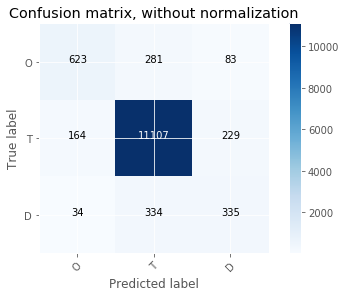

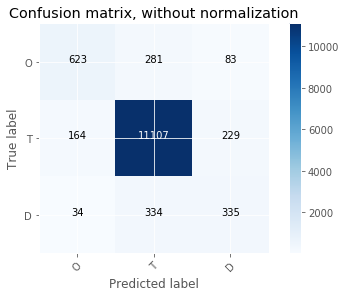

In [61]:
plt.figure()
plot_confusion_matrix(p, classes=tags,
                      title='Confusion matrix, without normalization')
plt.show()


In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [64]:
from sklearn.metrics import classification_report

report = classification_report(y_pred=predicted, y_true=actual)

In [65]:
print(report)

             precision    recall  f1-score   support

          D       0.76      0.63      0.69       987
          O       0.95      0.97      0.96     11500
          T       0.52      0.48      0.50       703

avg / total       0.91      0.91      0.91     13190

